In [20]:
import re
import numpy as np
import os
import pandas as pd
import nltk
import sklearn
from sklearn.model_selection import train_test_split
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchtext
from collections import Counter
import sklearn
import re
import random
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score, confusion_matrix
import matplotlib.pyplot as plt; plt.rcdefaults()
import string
from pattern.en import suggest
import ktrain
from ktrain import text
import seaborn as sns
import tensorflow as tf
from tqdm import tqdm
import math
import random
import emoji
import nlpaug.augmenter.word as naw
import sklearn
from imblearn.over_sampling import SMOTE
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
# import of custom functions from local files
from twitterFunctions.processing import processMe,process_token_fin,fix_emotes

In [2]:
# load training data
file = "./data/training_posts20201201_main_categories.tsv"
# read training data
df = pd.read_csv(file, sep="\t")

In [3]:
# remove exxagerations, we tested the impact, but ended up using the full data
#df = df[df["ambiguous"] != "exaggeration"]

In [4]:
# filter relevant columns
df = df[["notserious_unclear", "focus", "type", "about_suicide", "contents"]]
# rename class and text columns
colNames = ["notserious_unclear", "focus", "type", "class", "text"]
df.columns=colNames
# mapping of 0's and 1's to correct and false
di = {
    1: "correct", # you can map it as you see fit
    0: "false",
}

df["class"].replace(di, inplace=True)

In [5]:
df.head()

,notserious_unclear,focus,type,class,text
0,0,1,4,correct,This is why joking about suicide on social med...
1,0,1,4,correct,Impulse - Ellen Hopkins-three teens meet in ho...
2,0,1,4,correct,@User A darker subjectPeople who want to commi...
3,0,1,4,correct,"@User Dear God,Please continue working miracle..."
4,0,1,4,correct,It Just Keeps Getting Worse: The Braxton Caner...


<module 'matplotlib.pyplot' from 'C:\\Users\\Hubert\\AppData\\Roaming\\Python\\Python36\\site-packages\\matplotlib\\pyplot.py'>

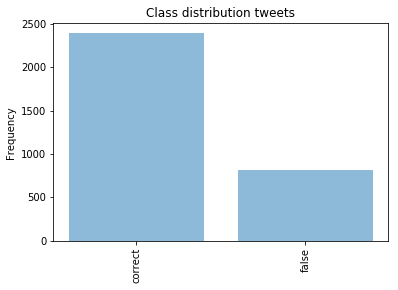

In [6]:
# here we print the class frequency distributions
freq_combined = Counter(df["class"].values)
objects = []
values = []
for i in freq_combined.keys():
    objects.append(i)
for i in freq_combined.values():
    values.append(i)
    
y_pos = np.arange(len(objects))

plt.bar(y_pos, values, align='center', alpha=0.5)
plt.xticks(y_pos, objects)
plt.ylabel('Frequency ')
plt.title('Class distribution tweets')
plt.xticks(rotation=90)
plt

In [7]:
# we run the preprocessing from the /twitterFunctions/processing.py
# here we use 3 functions (each loops over the entire dataset, they have to run sequentailly)
# if it takes too long one can make one function with all preprocessing - this recudes the runtime significantly
temp = df.text.apply(processMe)
# emojy mapping
emojis = temp.apply(emoji.emojize)
emojis = emojis.apply(fix_emotes)
cleaned_text = emojis
X_train_str = process_token_fin(cleaned_text)

In [8]:
# train val and test split
# stratify=df["class"] ensures that the subsets contain a similar distributions as original data
X_train, X_test, y_train, y_test = train_test_split(X_train_str
                    , df["class"],test_size=0.2, random_state=1, stratify=df["class"])

X_train, X_val, y_train, y_val = train_test_split(X_train
                    , y_train,test_size=0.2, random_state=1, stratify=y_train)

In [9]:
# the model name can be any transformers model (see https://huggingface.co/transformers/pretrained_models.html)
modelName = "bert-base-uncased"
#modelName = "xlnet-base-cased"
# set default parameters for deep learning
lr = 5e-5
epoch = 3
seed = 1
maxlen = 512 # max 512 for BERT based models, for twitter we use visual anaylsis to reduces to ~100
# the smaller the lenght the quicker the training
classNames2 = y_train.unique()
t = text.Transformer(modelName, 
                     maxlen = maxlen,  
                         class_names = classNames2)
# to ensure as much reproducibility as possbile we set all python and package seeds
# BERT results still vary form run to run with fixed seeds and paramters due to internal segmentation
def set_seeds(seed):
    os.environ['PYTHONHASHSEED']=str(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)

# train function takes training texts, training labels, validation texts, and validation labels
# STRONGLY RECOMMNED USING adding a checkpoint folder by settting checkpoint_folder, e.g.:
# .., checkpoint_folder="D:/Huber/checkpoint/"
# this will save the paramters of each epoch. We can load the best one after training has finished
def train_learner(X_train, y_train, X_val, y_val, 
                  lr, epoch, seed, text_length , checkpoint_folder=None): 
    classNames = classNames2
    
    set_seeds(seed)

    t = text.Transformer(modelName, maxlen=text_length,  
                         class_names = classNames2)
    trn = t.preprocess_train(X_train,  y_train)
    val = t.preprocess_test(X_val, y_val)
    model2 = t.get_classifier()
    learner = ktrain.get_learner(model2, train_data=trn, val_data=val, batch_size=32)
    #learner.lr_find(max_epochs=5)
    learner.fit_onecycle(lr, epoch, checkpoint_folder=checkpoint_folder)
    return (learner, t, trn, val, model2)
    #return learner.lr_plot()
    
# function that returns performance metrics and confusion matrix / only prints to console
def get_performance(labels, pred, classNames, score="macro"):
    f1 = f1_score(labels, pred, average=score)
    prec = precision_score(labels, pred, average=score)
    rec  = recall_score(labels, pred, average=score)
    acc = accuracy_score(labels, pred)
    print("; Prec: ", prec, "; Rec: ", rec, "F1: ", f1,   "; Acc: ", acc)
    print(confusion_matrix(labels, pred))
    mat = confusion_matrix(labels, pred, labels=classNames)
    return mat
# function that uses a trained model and predicts on test set
def predict_test(X_test, learner, t, trn):
    trn=trn
    predictor=ktrain.get_predictor(learner.model, preproc=t)
    pred = predictor.predict(X_test)
    return (np.squeeze(pred),predictor)
# helper function used in synthetic data generation
def filter_df(X,y,cond):
    df_tr = pd.DataFrame({"text":X, "class":y})
    df_minority = df_tr[df_tr["class"]==cond]
    df_minority
    return df_minority

In [11]:
# running grid search training TFIDF and SVM
def run_SVM_CV(train_features, test_features, y_train, y_test, confusion = True, return_f1 = False, verbose = True):
    metrics = np.zeros(4)
    
    # if u want to add SMOTE, just uncomment it in the pipline and paramters!
    pipeline = Pipeline([
    ('vect', TfidfVectorizer()),  #CountVectorizer
 #  ("smote", SMOTE(random_state=1, n_jobs=-1)), #uncomment me if SMOTE
    ('clf', SVC(random_state=1)),
])

    # here we can play around with the parameters
    # for SVM params check https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html
    # for tfidf params check https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html
    
    parameters = {
      #  'vect__max_df': (0.5, 0.75, 1.0),
      #  "vect__stop_words":[None, "english"],
    'vect__max_features': (None, 10000, 25000, 50000),
   'vect__ngram_range': ( (1,1), (1, 2) ),  # unigrams or bigrams
    #    "smote__k_neighbors" : [5], # uncommnet me if SMOTE
        'clf__C': np.arange(0.01, 1.01, 0.1),
                        'clf__kernel' : [ "rbf", "linear"],
                      'clf__class_weight': ["balanced"],
                      "clf__decision_function_shape":["ovo", "ovr"], }
    scorer = sklearn.metrics.make_scorer(f1_score, average = 'macro')
    # cv=5 is a 5-fold cross validation
    gs_clf = GridSearchCV(pipeline, parameters, n_jobs=-1, verbose=1, cv=5, scoring=scorer)
    # runs gridsearch with pipeline and paramters 
    gs_clf.fit(train_features, y_train)
    print(gs_clf.best_params_)
    test_pred = gs_clf.predict(test_features)
    metrics+= [f1_score(y_test, test_pred, average="macro"),
                              precision_score(y_test, test_pred, average="macro"),
                              recall_score(y_test, test_pred, average="macro"),
                             accuracy_score(y_test, test_pred)
                      ]
    if verbose:
            print('F1: {:.3f} | Pr: {:.3f} | Re: {:.3f} | Accuracy: {:.3f} \n'.format(*metrics))
    if return_f1:
            return f1
    if confusion:
            print( confusion_matrix(y_test, test_pred))
    return gs_clf

Validation Performance: 

Fitting 5 folds for each of 320 candidates, totalling 1600 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    9.9s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   30.8s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done 1600 out of 1600 | elapsed:  3.8min finished


{'clf__C': 0.51, 'clf__class_weight': 'balanced', 'clf__decision_function_shape': 'ovo', 'clf__kernel': 'linear', 'vect__max_features': 10000, 'vect__ngram_range': (1, 2)}
F1: 0.748 | Pr: 0.740 | Re: 0.760 | Accuracy: 0.801 

[[323  60]
 [ 42  88]]
Test Performance: 

; Prec:  0.7503340730665522 ; Rec:  0.7692904997818107 F1:  0.7585284817943778 ; Acc:  0.8096723868954758
[[407  71]
 [ 51 112]]


(array([0.5, 1.5]), <a list of 2 Text yticklabel objects>)

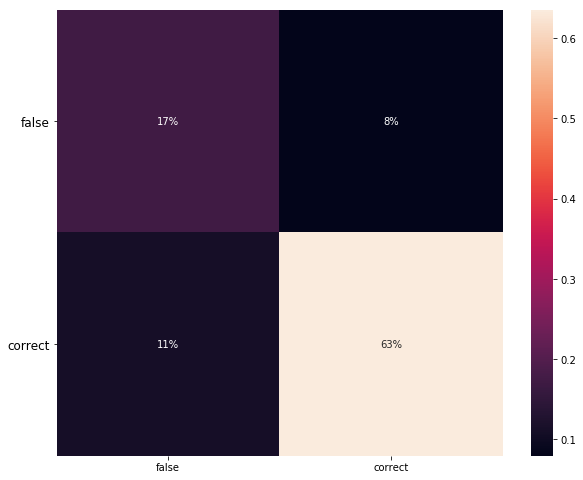

In [12]:
print("Validation Performance: \n")
model = run_SVM_CV(X_train, X_val, y_train, y_val)
pred = model.predict(X_test)
print("Test Performance: \n")
mat = get_performance(y_test.values, pred, classNames2)

labels = y_test.values
index = columns = classNames2
cm_df = pd.DataFrame(mat/np.sum(mat),columns,index)                      
plt.figure(figsize=(10,8.2))  
sns.heatmap(cm_df, annot=True, fmt=".0%"
           )
plt.yticks(rotation=0, fontsize=12) 

## Saving and loading sklearn models

for more information check out this article: 
https://machinelearningmastery.com/save-load-machine-learning-models-python-scikit-learn/

In [13]:
import pickle
# save the model to disk
filename = 'finalized_model.sav'
pickle.dump(model, open(filename, 'wb'))

In [14]:
# loading the model from disk
loaded_model = pickle.load(open(filename, 'rb'))
result = loaded_model.predict(X_test)
mat = get_performance(y_test.values, result, classNames2)


; Prec:  0.7503340730665522 ; Rec:  0.7692904997818107 F1:  0.7585284817943778 ; Acc:  0.8096723868954758
[[407  71]
 [ 51 112]]


## Training BERT model with original data

In [ ]:
original_learner = train_learner(
       X_train, y_train.values, 
        X_val, y_val.values,
        lr= 1.5e-5, epoch=1, seed=1, text_length=80 , # parameters for the training
        checkpoint_folder="D:/models/test/"   # add the path where the checkpoints should be saved
    )

## After the training has finished, you will see the training statistics. I usually choose the epoch with the highest validation accuracy (if two performances were similar I chose the one with the lower validation loss).

If you used a checkpoint folder, you can load the model with the best performance rather than the last epoch. E.g. if you trained for 5 epochs, the default behaviour is that the model will use the last run, i.e. epoch 5. But if the performance of epoch 5 is worse than epoch 3, you can manually load the weights of epoch 3. See below:

In [ ]:
original_learner[4].load_weights("D:/models/test/weights-01.hdf5") # your path + weights-01.hdf5
# where weights-*BEST_EPOCH*.hdf5

learner_reloaded = ktrain.get_learner(original_learner[4], train_data=original_learner[2], val_data=original_learner[3], batch_size=2)

model_ = learner_reloaded 
t_ = original_learner[1]
trn_ = original_learner[2]

# setting seeds (redundantly) before predicting validation set
set_seeds(seed)
# usually you only have to do this if you are interested in inter-class statistics of the valdiation set:D
## PREDICT ON VALIDATION SET
pred = predict_test(X_val, model_, 
                    t=t_,
                    trn=trn_)
predictor = pred[1]
val = t_.preprocess_test(X_val, y_val.values)
model_.validate(val_data= val )
mat = get_performance(y_val.values, pred[0], classNames2)

## PREDICT ON TEST SET
set_seeds(seed)
pred = predict_test(X_test, model_, 
                    t=t_,
                    trn=trn_)
predictor = pred[1]
test = t_.preprocess_test(X_test, y_test.values)
model_.validate(val_data= test , class_names = list(classNames2))
mat = get_performance(y_test.values, pred[0], classNames2)

In [ ]:
# in binary classification we can get interclass precision by using the confusion matrix
mat.diagonal()/mat.sum(axis=0)

## Saving a ktrain model

If the test performance was good, and you want to save the actual model (not only the weights of the training) call **predictor.save( "yourPath")**.

In [ ]:
# saving the best model / predictor
predictor.save('D:/models/Twitter_about_suicide_final')

In [ ]:
#mat = get_performance(y_test.values, pred, classNames2)
mat = [[21,5], [10,64]]
labels = y_test.values
capitalized = [i.capitalize() for i in classNames2]
index = columns = capitalized
cm_df = pd.DataFrame(mat/np.sum(mat),columns,index)                      
plt.figure(figsize=(6,4.92))  
sns.heatmap(cm_df, annot=True, fmt=".0%"
           )
plt.yticks(rotation=0, fontsize=12) 
plt.xlabel("Predicted class", fontsize=20)
plt.ylabel("Original class", fontsize=20)
plt.title("Confusion matrix test set, n=641", fontsize=20)
plt.show()

# Testing undersampling

In [16]:
# create two subset that only contain correct / false classes respectively
major = filter_df(X_train,y_train.values,"correct")
minor = filter_df(X_train,y_train.values,"false")

In [17]:
seed = 1
set_seeds(seed)
# sample number of minority observations from majoriy df
AS = major.sample(n=int(minor.shape[0]),  random_state=seed)

In [18]:
df_new = AS
df_train = minor
df_train = df_train.append(df_new, ignore_index = True)
Counter(df_train["class"])

Counter({'false': 520, 'correct': 520})

In [ ]:
# trainign undersampled learner
undersampled_learner = train_learner(
        df_train.text.values, df_train["class"].values,
        X_val, y_val.values,
       5e-5, 3, 2, 80
)

In [ ]:
undersampled_learner[0].validate(class_names = list(classNames2))

In [ ]:
set_seeds(seed)

pred = predict_test(X_test, undersampled_learner[0], 
                    t=undersampled_learner[1],
                    trn=undersampled_learner[2])

test = undersampled_learner[1].preprocess_test(X_test, y_test.values)
undersampled_learner[0].validate(val_data= test , class_names = list(classNames2))

In [ ]:
mat = get_performance(y_test.values, pred, classNames2)
labels = y_test.values
index = columns = classNames2
cm_df = pd.DataFrame(mat/np.sum(mat),columns,index)                      
plt.figure(figsize=(10,6))  
sns.heatmap(cm_df, annot=True, fmt=".0%"
           )
plt.yticks(rotation=0) 
plt.xlabel("Predicted class")
plt.ylabel("Original class")
plt.title("Confusion matrix test set, n=641")


In [ ]:
#undersampled_learner[0].model.save_pretrained("D:/models/Suicidality_BERT_Undersampled_best")

# Testing WordNet Synonym Lookup (get new df_train)

This functions basically does three things.
1. determine the majority class, get its frequency and ingore it.
2. iterate through all remaining classes and:
    use wordnet to replace aug_p words.
    repeat until the class frequency == majority class frequency.
   
The result is a perfectly balanced training dataset, i.e. all classes have the same number of observations. Above you can find the code how to sample from a saved csv file. (see section @Use this when you have a synthetic training set already and want to continue training with synthetic training set.)

In [21]:
# set augmentation probability
aug_p = 0.3

new_texts = []
new_classes = []
np.random.seed(1)
random.seed(1)
freq_origin = Counter(y_train.values)
majority_freq =  freq_origin.most_common()[0][1]
majority_class = freq_origin.most_common()[0][0]
seed = 1
aug = naw.SynonymAug(aug_src='wordnet',
                     aug_p=aug_p)
for i in tqdm(freq_origin.most_common()):
    df_tmp = filter_df(X_train, y_train.values, i[0])
    if i[0] == majority_class:
        print("getting base frequency")
    else:
        num_lang = ( (majority_freq-i[1]) /  i[1] )
        num_samples = num_lang * i[1]
        if num_samples < i[1]:
            AS = df_tmp["text"].sample(n=int(num_samples),  random_state=seed)
            TT = AS.values.tolist()
            for tweet in TT:
                augmented_text = aug.augment(tweet)
                new_texts.append(augmented_text)
                new_classes.append(i[0])
        else:
            for j in range(math.ceil(num_lang)):
                if num_samples < i[1]:
                    AS = df_tmp["text"].sample(n=int(num_samples),  random_state=seed)
                    TT = AS.values.tolist()
                    for tweet in TT:
                        augmented_text = aug.augment(tweet)
                        new_texts.append(augmented_text)
                        new_classes.append(i[0])
                else:
                    # translate entire set once
                    AS = df_tmp["text"]
                    TT = AS.values.tolist()
                    for tweet in TT:
                        augmented_text = aug.augment(tweet)
                        new_texts.append(augmented_text)
                        new_classes.append(i[0])
                    num_samples -= len(TT)        
    seed+=1
    print("done, first class", i[0])

  0%|                                                                                            | 0/2 [00:00<?, ?it/s]

getting base frequency
done, first class correct


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [01:50<00:00, 55.24s/it]

done, first class false


## saving the dataset (uncomment)

In [22]:
df_new = pd.DataFrame({
    "text": new_texts, 
    "class": new_classes
})

df_train = pd.DataFrame({
    "text": X_train, 
    "class":  y_train.values
})
# appending the synthetic data to the orinignal traning data
df_train = df_train.append(df_new, ignore_index = True)
print(Counter(df_train["class"]))

# if you want to save or load use this: (uncommented ofc)
#df_train.to_csv("40pc_oversampled.csv", sep="|")
#df_train = pd.read_csv("40pc_oversampled.csv", sep="|")

Counter({'false': 1528, 'correct': 1528})


# PPDB synonym lookup (get new df_train)

This functions basically does three things.
1. determine the majority class, get its frequency and ingore it.
2. iterate through all remaining classes and:
    use PPDB to replace aug_p words.
    repeat until the class frequency == majority class frequency.
   
The result is a perfectly balanced training dataset, i.e. all classes have the same number of observations. Above you can find the code how to sample from a saved csv file. (see section @Use this when you have a synthetic training set already and want to continue training with synthetic training set.)

In [23]:
# set augmentation probability
aug_p = 0.2

new_texts = []
new_classes = []
np.random.seed(1)
random.seed(1)
freq_origin = Counter(y_train.values)
majority_freq =  freq_origin.most_common()[0][1]
majority_class = freq_origin.most_common()[0][0]
seed = 1
# download model here:
    # http://nlpgrid.seas.upenn.edu/PPDB/eng/ppdb-2.0-tldr.gz
# and change the model path:
aug = naw.SynonymAug(aug_src='ppdb', model_path="D:\models\ppdb-2.0-tldr\ppdb-2.0-tldr",
                     aug_p=aug_p)
for i in tqdm(freq_origin.most_common()):
    df_tmp = filter_df(X_train, y_train.values, i[0])
    if i[0] == majority_class:
        print("getting base frequency")
    else:
        num_lang = ( (majority_freq-i[1]) /  i[1] )
        num_samples = num_lang * i[1]
        if num_samples < i[1]:
            AS = df_tmp["text"].sample(n=int(num_samples),  random_state=seed)
            TT = AS.values.tolist()
            for tweet in TT:
                augmented_text = aug.augment(tweet)
                new_texts.append(augmented_text)
                new_classes.append(i[0])
        else:
            for j in range(math.ceil(num_lang)):
                if num_samples < i[1]:
                    AS = df_tmp["text"].sample(n=int(num_samples),  random_state=seed)
                    TT = AS.values.tolist()
                    for tweet in TT:
                        augmented_text = aug.augment(tweet)
                        new_texts.append(augmented_text)
                        new_classes.append(i[0])
                else:
                    # translate entire set once
                    AS = df_tmp["text"]
                    TT = AS.values.tolist()
                    for tweet in TT:
                        augmented_text = aug.augment(tweet)
                        new_texts.append(augmented_text)
                        new_classes.append(i[0])
                    num_samples -= len(TT)        
    seed+=1
    print("done, first class", i[0])

  0%|                                                                                            | 0/2 [00:00<?, ?it/s]

getting base frequency
done, first class correct


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [01:50<00:00, 55.47s/it]

done, first class false


In [24]:
# this combines the original dataframe with the synthetic one
df_new = pd.DataFrame({
    "text": new_texts, 
    "class": new_classes
})

df_train = pd.DataFrame({
    "text": X_train, 
    "class":  y_train.values
})

df_train = df_train.append(df_new, ignore_index = True)

print(Counter(df_train["class"]))

# saving the data (the translation takes a while, saving is recommended and can be skipped once u have the csv)
# df_train.to_csv("40pc_oversampled.csv", sep="|")

Counter({'false': 1528, 'correct': 1528})


# Use this code chunk to modify the amount of synthetic data that will be added to the original data. 

By default it will be 100% syntehtic data, i.e. the final class distribtuion frequency will be the exact same for both classes.

In [25]:
# load syntehtic training data if saved
#df_train = pd.read_csv("40pc_oversampled.csv", sep="|")

# I always append the synthetic samples to the original training data
# this ensures that df_train_en only contains the original training data
df_train_en = df_train.iloc[0:len(X_train)]
# determine the fraction of syntehtic data you want to add
fc_ = 0.3
# remove original training data from full training data (original + synthetic)
a = df_train.drop(df_train_en.index, axis=0)
# randomly sample fc_ fraction of synthtic data
b = a.sample(random_state=1, frac=fc_)
# add fc_ synthetic data to original
c = df_train_en.append(b, ignore_index=True)
# randomly shuffle final training data (original + fc_ syntetic)
df_train = c.sample(frac=1)

print( Counter(df_train["class"].values))

Counter({'correct': 1528, 'false': 822})


# Code chunk that can be used to train with df_train (for all synthetic data)

In [ ]:
oversampled_learner = train_learner(
        df_train.text.values, df_train["class"].values, #X_train, y_train.values,
        X_val, y_val.values,
        lr= 1.5e-5, epoch=5, seed=1, text_length=80 , # parameters for the training
        checkpoint_folder="D:/models/test/"   # add the path where the checkpoints should be saved
    )

In [ ]:
oversampled_learner[0].validate(class_names = list(classNames2))

In [ ]:
set_seeds(seed)

pred = predict_test(X_test, oversampled_learner[0], 
                    t=oversampled_learner[1],
                    trn=oversampled_learner[2])

test = oversampled_learner[1].preprocess_test(X_test, y_test.values)
oversampled_learner[0].validate(val_data= test , class_names = list(classNames2))

In [ ]:
mat = get_performance(y_test.values, pred, classNames2)
labels = y_test.values
index = columns = classNames2
cm_df = pd.DataFrame(mat,columns,index)                      
plt.figure(figsize=(10,6))  
sns.heatmap(cm_df, annot=True)

In [ ]:
df_test = pd.DataFrame({
    "text": X_test, 
    "true_label": y_test,
    "predicted_label": pred
})


## The code below helps us visualize the models decisions

I used this and below you can also see the code for the word clouds

In [ ]:
a = reloaded_predictor.explain(X_test[0],all_targets=False)

In [ ]:
reloaded_predictor.explain(X_test[0])
#a = reloaded_predictor.explain(X_test[0],weights_df=True,all_targets=False)

In [ ]:
import eli5
from eli5.lime import TextExplainer
doc = X_test[0]

In [ ]:
te = TextExplainer(random_state=42, n_samples=2500)
_ = te.fit(doc, reloaded_predictor.predict_proba)

In [ ]:
labels[0:1]

In [ ]:
a = te.explain_prediction(target_names = reloaded_predictor.c, targets= [pred[0]])

In [ ]:
a

In [ ]:
from eli5 import formatters

In [ ]:
from tqdm import tqdm
c = 0
c1 = []
c2 = []
c3 = []
c4 = []
for i in tqdm(X_test):
    doc = i
    te = TextExplainer(random_state=42, n_samples=1500)
    _ = te.fit(doc, reloaded_predictor.predict_proba)
    a = te.explain_prediction(target_names = reloaded_predictor.c, targets= [pred[c]])
    df_weights = formatters.format_as_dataframe(a)
    c+=1
    c1.append(df_weights[0:1].values[0][1])
    c2.append(df_weights[1:2].values[0][1])
    c3.append(df_weights[2:3].values[0][1])
    c4.append(df_weights[3:4].values[0][1])

In [ ]:
df_test = pd.DataFrame({
    "text": X_test, 
    "true_label": y_test,
    "predicted_label": pred,
    "1st feature":c1,
    "2nd feature":c2,
    "3rd feature":c3,
    "4th feature":c4
})

In [ ]:
df_test.to_csv("test_withPredictions.csv",index=False)

In [ ]:
df_test.head()

In [ ]:
from wordcloud import WordCloud
Counter(df_test["predicted_label"])

In [ ]:
dfdf = df_test[df_test["predicted_label"]=="Bereaved_negative"]

In [ ]:
dfdf

In [ ]:
a = dfdf["1st feature"].values
b = dfdf["2nd feature"].values
c = dfdf["3rd feature"].values
d = dfdf["4th feature"].values

In [ ]:
A = np.concatenate((a,b,c,d))
tuples = [tuple(x) for x in a]
fin = ""
for i in A:
    fin+=i+ " "

In [ ]:
wordcloud = WordCloud(width=800, height=400).generate(fin)
plt.figure(dpi=800, facecolor='k')
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()
#plt.savefig("graph.svg")
